In [1]:
!pip install yfinance --upgrade --quiet

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid

In [3]:
# Download Nifty data
data = yf.download("RELIANCE.NS", start="2022-01-01", end="2025-01-01")
data.dropna(inplace=True)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [4]:
print(data.columns)

MultiIndex([( 'Close', 'RELIANCE.NS'),
            (  'High', 'RELIANCE.NS'),
            (   'Low', 'RELIANCE.NS'),
            (  'Open', 'RELIANCE.NS'),
            ('Volume', 'RELIANCE.NS')],
           names=['Price', 'Ticker'])


In [5]:
# Flatten MultiIndex columns and remove ticker suffix (e.g., "High_^NSEI" → "High")
data.columns = [col[0] if isinstance(col, tuple) else col for col in data.columns]
print(data.columns)
data.head()

Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')


,Close,High,Low,Open,Volume
Date,,,,,
2022-01-03,1105.768433,1107.654491,1087.230530,1087.897543,5421611
2022-01-04,1130.723389,1132.057415,1105.837424,1111.311506,10847728
2022-01-05,1136.013428,1139.417482,1119.154494,1132.517510,11643813
2022-01-06,1111.587524,1128.837516,1108.137477,1127.549483,14447422
2022-01-07,1120.557495,1130.700426,1109.310500,1118.234508,13112115


In [6]:
print(data[['High', 'Low', 'Close', 'Volume']].isna().sum())

High      0
Low       0
Close     0
Volume    0
dtype: int64


In [7]:
data.head()

,Close,High,Low,Open,Volume
Date,,,,,
2022-01-03,1105.768433,1107.654491,1087.230530,1087.897543,5421611
2022-01-04,1130.723389,1132.057415,1105.837424,1111.311506,10847728
2022-01-05,1136.013428,1139.417482,1119.154494,1132.517510,11643813
2022-01-06,1111.587524,1128.837516,1108.137477,1127.549483,14447422
2022-01-07,1120.557495,1130.700426,1109.310500,1118.234508,13112115


In [8]:
# Calculate Typical Price (High + Low + Close) / 3
data['typical_price'] = (data['High'] + data['Low'] + data['Close']) / 3

In [9]:
def run_strategy(df, window=30, entry_threshold=2, exit_threshold=0.5,
                 stop_loss=0.01, profit_target=0.04, cost_per_trade=0.001):
    df = df.copy()
    
    # Calculate Z-Score
    df['mean_price'] = df['typical_price'].rolling(window).mean()
    df['std_price'] = df['typical_price'].rolling(window).std()
    df['z_score'] = (df['typical_price'] - df['mean_price']) / df['std_price']
    
    # Generate signals
    df['signal'] = 0
    df['signal'] = np.where(df['z_score'] < -entry_threshold, 1, 
                           np.where(df['z_score'] > entry_threshold, -1, 0))
    df['signal'] = np.where((df['z_score'] > -exit_threshold) & 
                           (df['z_score'] < exit_threshold), 0, df['signal'])
    
    # Track positions and PnL
    df['active_positions'] = [[] for _ in range(len(df))]  # List of open positions per day
    df['closed_pnl'] = 0.0  # PnL from closed positions
    df['transaction_cost'] = 0.0
    
    open_positions = []  # Format: [{'entry_price': float, 'position': 1/-1, 'entry_date': date}]

    for idx, row in df.iterrows():
        current_price = row['typical_price']
        daily_closed_pnl = 0.0
        daily_transaction_cost = 0.0
        
        # 1. Check existing positions for closure
        positions_to_remove = []
        for pos in open_positions:
            pnl = (current_price - pos['entry_price'])/pos['entry_price'] if pos['position'] == 1 \
                   else (pos['entry_price'] - current_price)/pos['entry_price']
            
            if pnl <= -stop_loss or pnl >= profit_target:
                daily_closed_pnl += pnl
                positions_to_remove.append(pos)
                daily_transaction_cost += cost_per_trade  # Exit cost
        
        # Remove closed positions
        for pos in positions_to_remove:
            open_positions.remove(pos)
        
        # 2. Enter new positions if signal != 0
        if row['signal'] != 0:
            open_positions.append({
                'entry_price': row['typical_price'],
                'position': row['signal'],
                'entry_date': idx
            })
            daily_transaction_cost += cost_per_trade  # Entry cost
        
        # 3. Update DataFrame
        df.at[idx, 'closed_pnl'] = daily_closed_pnl
        df.at[idx, 'transaction_cost'] = daily_transaction_cost
        df.at[idx, 'active_positions'] = open_positions.copy()  # Store open positions
    
    # Calculate strategy returns (PnL - costs)
    df['strategy_return'] = df['closed_pnl'] - df['transaction_cost']
    
    return df

In [10]:
# Performance Metrics
def compute_metrics(returns):
    cumulative = (1 + returns).cumprod()
    total_return = cumulative.iloc[-1] - 1
    sharpe_ratio = (returns.mean() / returns.std()) * np.sqrt(252)
    max_drawdown = (cumulative / cumulative.cummax() - 1).min()
    return {
        'Total Return': total_return,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown
    }

In [11]:
# Split data into training (70%) and testing (30%)
split_date = data.index[int(len(data)*0.7)]
train_data = data.loc[:split_date]
test_data = data.loc[split_date:]

# Optimize parameters on training data
param_grid = {
    'window': [10, 15, 20, 25, 30, 35, 40],
    'entry_threshold': [1.0, 1.5, 2.0],
    'exit_threshold': [0.5, 1.0],
    'stop_loss': [0.005, 0.01, 0.015, 0.02, 0.025, 0.03],
    'profit_target': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1],
    'cost_per_trade': [0.001]
}

best_sharpe = -np.inf
best_params = {}

for params in ParameterGrid(param_grid):
    # Run strategy with current parameters
    trained_data = run_strategy(train_data, **params)
    metrics = compute_metrics(trained_data['strategy_return'].dropna())
    
    if metrics['Sharpe Ratio'] > best_sharpe:
        best_sharpe = metrics['Sharpe Ratio']
        best_params = params

print("Train Metrics:", metrics)
print("Best Parameters:", best_params)

# Test optimized parameters on unseen data
test_results = run_strategy(test_data, **best_params)
metrics_test = compute_metrics(test_results['strategy_return'].dropna())
print("Test Metrics:", metrics_test)

optimized_data = run_strategy(data, **best_params)

Train Metrics: {'Total Return': 0.1718911074661178, 'Sharpe Ratio': 0.4106854140382022, 'Max Drawdown': -0.5560992088674535}
Best Parameters: {'cost_per_trade': 0.001, 'entry_threshold': 1.0, 'exit_threshold': 0.5, 'profit_target': 0.1, 'stop_loss': 0.005, 'window': 40}
Test Metrics: {'Total Return': 0.3662120899154908, 'Sharpe Ratio': 0.7189233529410628, 'Max Drawdown': -0.40979982767471335}


In [12]:
metrics = compute_metrics(optimized_data['strategy_return'].dropna())
print("\nPerformance Metrics:", metrics)


Performance Metrics: {'Total Return': 1.9924241365618882, 'Sharpe Ratio': 0.7819221003834873, 'Max Drawdown': -0.8073404055937888}


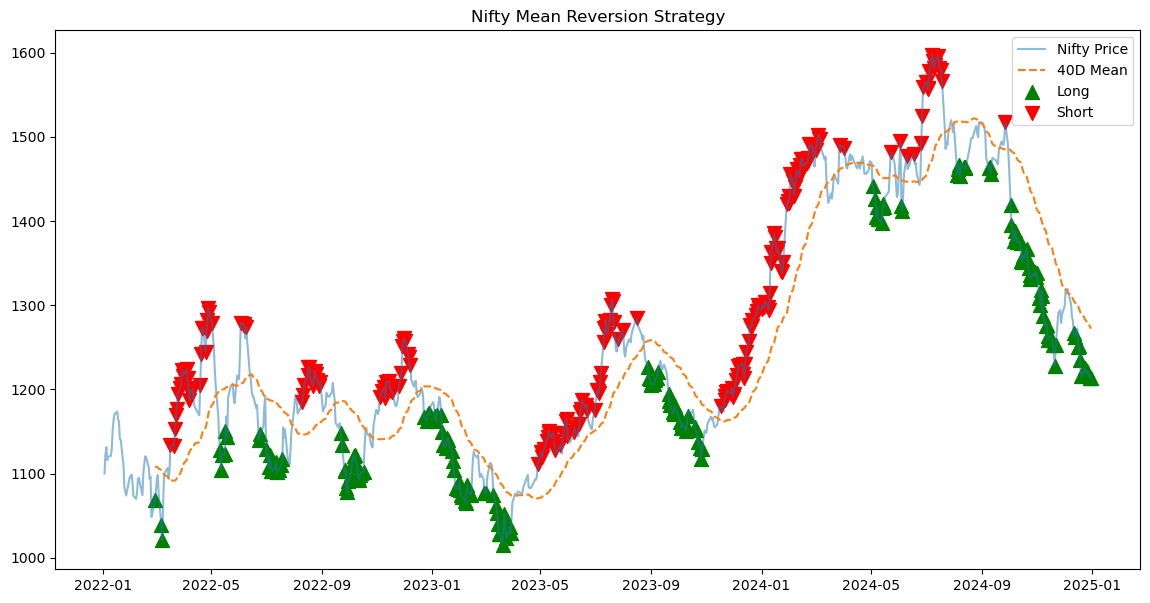

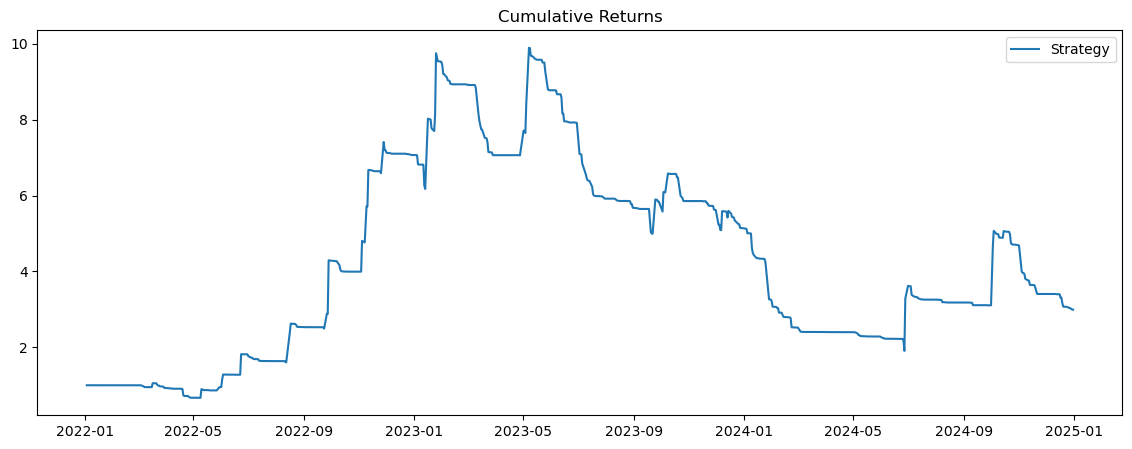

In [13]:
plt.figure(figsize=(14, 7))
plt.plot(optimized_data['typical_price'], label='Nifty Price', alpha=0.5)
plt.plot(optimized_data['mean_price'], label=f'{params["window"]}D Mean', linestyle='--')

# Long signals
plt.scatter(optimized_data[optimized_data['signal'] == 1].index,
            optimized_data[optimized_data['signal'] == 1]['typical_price'],
            marker='^', color='g', s=100, label='Long')

# Short signals
plt.scatter(optimized_data[optimized_data['signal'] == -1].index,
            optimized_data[optimized_data['signal'] == -1]['typical_price'],
            marker='v', color='r', s=100, label='Short')

plt.title('Nifty Mean Reversion Strategy')
plt.legend()
plt.show()

# Equity curve
plt.figure(figsize=(14, 5))
plt.plot((1 + optimized_data['strategy_return']).cumprod(), label='Strategy')
plt.title('Cumulative Returns')
plt.legend()
plt.show()

In [14]:
# View open positions on a specific date
print(optimized_data.loc['2023-06-01', 'active_positions'])

[{'entry_price': 1162.6411539713542, 'position': -1, 'entry_date': Timestamp('2023-05-29 00:00:00')}, {'entry_price': 1164.8256022135417, 'position': -1, 'entry_date': Timestamp('2023-05-30 00:00:00')}, {'entry_price': 1144.6349690755208, 'position': -1, 'entry_date': Timestamp('2023-05-31 00:00:00')}]


In [15]:
# Get all closed trades
closed_trades = []
for idx, row in optimized_data.iterrows():
    if row['closed_pnl'] != 0:
        closed_trades.append({
            'date': idx,
            'pnl': row['closed_pnl'],
            'cost': row['transaction_cost']
        })
print(pd.DataFrame(closed_trades).head())

        date       pnl   cost
0 2022-03-07 -0.028157  0.002
1 2022-03-08 -0.016557  0.002
2 2022-03-17  0.109990  0.002
3 2022-03-22 -0.034468  0.003
4 2022-03-23 -0.014276  0.002


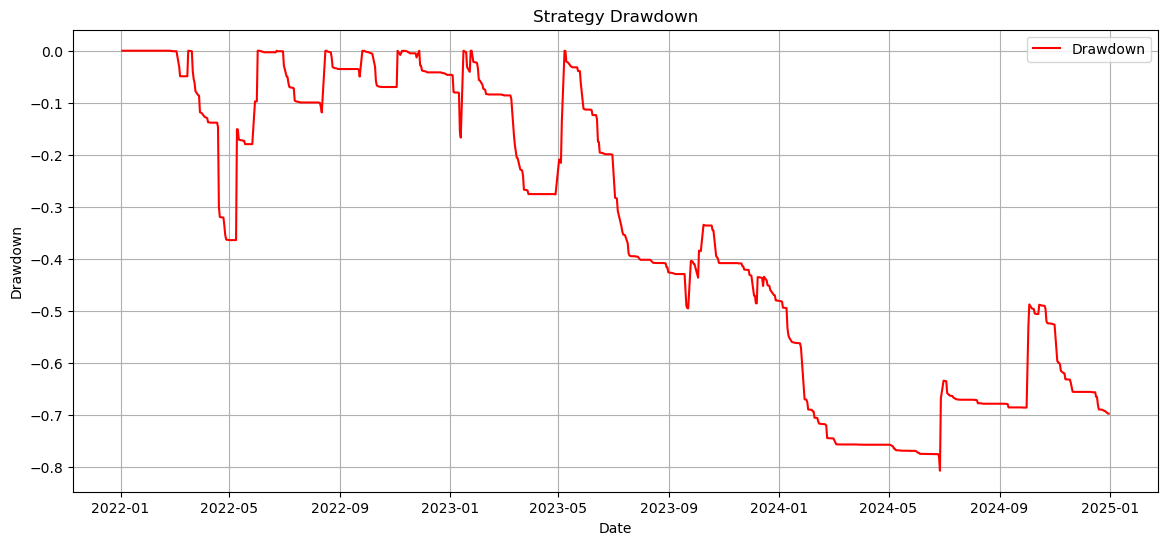

In [16]:
# Drawdowns
plt.figure(figsize=(14, 6))
cumulative = (1 + optimized_data['strategy_return']).cumprod()
rolling_max = cumulative.cummax()
drawdown = (cumulative - rolling_max) / rolling_max
plt.plot(drawdown, label='Drawdown', color='red')
plt.title('Strategy Drawdown')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()
plt.grid(True)
plt.show()